In [ ]:
#INDEX 

#1. variables: user changes as needed - this should be the only part you have to change
#2. dependencies and functions
#3. read touch sensor data and save when touch sensors are active 
#4. calculate position per frame based on which touch sensors are active and make indices for movement bouts
#5. calculate whether mouse is going forward or backward per movement bout 
#6. check your parsing is ok if you want 
#7. parse movement bouts into separate mat files 
#8. parse movement bouts into separate video files if you want 

In [9]:
#VARIABLES

file_dir = '/Users/riccellit/Desktop/sensordata/cwa_S27_session01_seq1_gr00_2' #Full path to file+filename WITHOUT file type (eg no '.mat') 
#both video and sensor files need to have the same name 


#fill in information for outfile name 

fps = 30 #frames per second
subject = 'mouse1' #subject
session = '01' #session (2 digits, e.g. "02" if 2nd session)
seq = '1' #1 or 2 
grade = '00' #00 or 20 

save_dir = '/Users/riccellit/Desktop/folder' #directory to save data in 



In [2]:
#DEPENDENCIES AND FUNCTIONS

#ignore deprecation warnings
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

import os, sys 
import h5py
import hdf5storage
import numpy as np 
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import seaborn as sns
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip



#function to identify 1 location in array 
def one_runs(a):
    # Create an array that is 1 where a is 1, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 1).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

#function to identify 0 location in array 
def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

#graph the linear regression 
def graph(lambdafx, x_range):  
    x = np.array(x_range)  
    y = lambdafx(x) 
    ax = plt.plot(x, y, color = 'tab:blue') 

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#READ TOUCH SENSOR DATA 

f = h5py.File(file_dir+'.mat', 'r')

Sensor = []

#shape is approximating number frames 
struArray = f['sns']
shape = struArray['sns'].shape
shape = shape[0] - 1 

while shape > 0: 
    value = f[struArray['sns'][shape,0]].value 
    Sensor.append(value)
    shape = shape - 1 
            
#remove extraneous array bracket 
frames = np.array([e[0] for e in Sensor])

#find location of 1 runs where 1 indicates touch and 0 indicates no touch(e.g. frames with touches)
OnesLoc = []
for array in frames.T: 
    OnesLoc.append(one_runs(array))

In [4]:
#GET POSITION OF MOUSE

#parse out reward ports 
frames = frames.T[5:94]
frames = frames.T

#get average position based on sensors activated 
position = []
for array in frames: 
    sensorindices = [i for i, x in enumerate(array) if x == 1]
    position.append(np.nanmean(sensorindices))

#movement defined when any sensor becomes first active, until sensor becomes not active 
mask = ma.masked_invalid(position)
mask2 = [int(x) for x in ma.getmask(mask)]

diff = np.diff((np.asarray(mask2)).flatten())
indices = [i for i, x in enumerate(diff) if x != 0]

#Add in the first and last indices as they will not be caught by the mask (eg, 0, max length)
indices.append(len(frames)) 
indices = [0] + indices
    

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


In [5]:
#FIND DIRECTION OF MOVEMENT BOUT 

#where 1 is forward, 0 is backward 
#basically simple subtraction of position at beginning and end 
if np.isnan(position[(indices[0]+1)] - position[indices[1]]) == True: #sometimes indices offset 
    del indices[0]
    
direction = []
for i,x in enumerate(indices):
    if i < len(indices)-2: #because comparison won't work for last index 
        if (i+2)%2 == 0:  #if the number is even 
            if position[(indices[i]+1)] - (position[indices[i+1]]) > 40: 
                direction.append(1) #forward
            elif position[(indices[i]+1)] - (position[indices[i+1]]) < -40: 
                direction.append(0) #backward 
            else: 
                direction.append(None) #not long enough bout of movement
        else: 
            direction.append(direction[-1]) #append the last value for 2nd number  
    else: 
        direction.append(direction[-1]) #append the last value 
        
#making dataframe for visualization purposes and also functions
d = {'indices':indices, 'direction':direction}
df = pd.DataFrame(data=d)

#making boolean mask of indices for forward and backward movement 
df['notna'] = pd.notna(df['direction'])
df['forward'] = df['direction'] ==1
df.forward = df.forward.astype(int)
df['backward'] = df['direction'] == 0
df.backward = df.backward.astype(int)

#get ranges, do a little bit of clean up, and convert to ms 
fsample = [] #for graph check
bsample =[] #for graph check 


for index, boolean in enumerate(df['forward'].values, start=0): 
    if index < len(df)-1:
        if (index + 2) %2 ==0: 
            if boolean == 1: 
                fsample.append([df['indices'][index],df['indices'][index+1]])
            else: 
                pass 
        else: 
            pass
    else: 
        pass
for index, boolean in enumerate(df['backward'].values, start=0): 
    if index < len(df)-1:
        if (index + 2) %2 == 0: 
            if boolean == 1: 
                bsample.append([df['indices'][index],df['indices'][index+1]])
            else: 
                pass 
        else: 
            pass 
    else: 
        pass 
    
#cleaning up thte tails of array
backwardRanges = []
for array in bsample: 
    section = position[array[0]: array[1]]
    index = np.where(section == np.nanmin(section))[0][len(np.where(section == np.nanmin(section))[0])-1] 
    index2 = np.where(section==np.nanmax(section))[0][0] 
    backwardRanges.append([(array[0] + index), (array[0] + index2)])
forwardRanges = [] 
for array in fsample:
    section = position[array[0]: array[1]]
    index = np.where(section == np.nanmax(section))[0][len(np.where(section == np.nanmax(section))[0])-1]
    index2 = np.where(section==np.nanmin(section))[0][0] 
    forwardRanges.append([(array[0] + index), (array[0] + index2)])


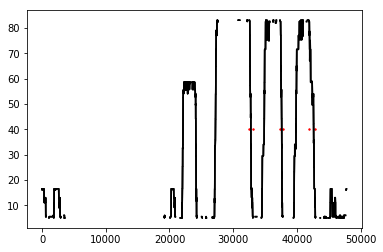

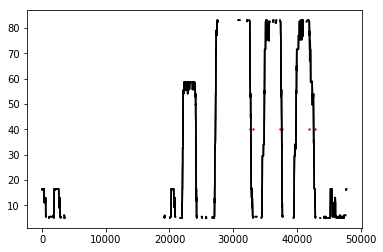

In [7]:
#CHECK THAT INDICES MATCH POSITION 

# for array in forwardRanges: 
#     plt.plot(position, color = 'k') 
#     plt.scatter(array[0],[40], s= 2, color = 'r')
#     plt.scatter(array[1],[40], s =2, color = 'r') 
# plt.show()


# for array in backwardRanges: 
#     plt.plot(position, color = 'k') 
#     plt.scatter(array[0],[40], s= 2, color = 'b')
#     plt.scatter(array[1],[40], s =2, color = 'b') 
# plt.show()


In [11]:
#PARSE OUT MOVEMENT BOUTS AND SAVE AS SEPARATE MAT FILES 

#doing forward trials 
trial = 0
for array in forwardRanges:
    trial = trial + 1
    print("Analyzing " + str(trial) + " forward...")
        
    cropSensor = Sensor[(array[0]): array[1]]
            
    matfiledata = {} 
    matfiledata[u'sns'] = cropSensor
    hdf5storage.savemat(save_dir + '/' + str(subject) + '_' + str(trial) + '_f_' + str(session) + '.mat', 
                        matfiledata, format='7.3', oned_as='column')
        
    print("...file analyzed and saved.")
    
#doing backward files    
trial = 0
for array in backwardRanges:
    trial = trial + 1
    print("Analyzing " + str(trial) + " backward...")
        
    cropSensor = Sensor[(array[0]): array[1]]
            
    matfiledata = {} 
    matfiledata[u'sns'] = cropSensor
    hdf5storage.savemat(save_dir + '/' + str(subject) + '_' + str(trial) + '_b_' + str(session) + '.mat', 
                        matfiledata, format='7.3', oned_as='column')
        
    print("...file analyzed and saved.")



Analyzing 1 forward...
...file analyzed and saved.
Analyzing 2 forward...
...file analyzed and saved.
Analyzing 3 forward...
...file analyzed and saved.
Analyzing 1 backward...
...file analyzed and saved.
Analyzing 2 backward...
...file analyzed and saved.
Analyzing 3 backward...
...file analyzed and saved.


In [ ]:
# #CROP VIDEO IF YOU WANT- THIS WILL TAKE A WHILE

# trial = 0 
# for array in forwardRanges:
#     trial = trial+1
    
#     start_time = array[0]/fps #convert to s 
#     end_time = array[1]/fps
    
#     ffmpeg_extract_subclip(file_dir + ".avi")

# #print(trial)
